# Gesture Recognition
In this group project, we are going to build a 3D Conv model & 2D Conv+RNN that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 460kB 50.0MB/s 
     |████████████████████████████████| 3.0MB 49.2MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [3]:
pip install scipy==1.2.0

     |████████████████████████████████| 26.6MB 165kB/s 
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.2.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation & also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
#Data is stored on google drive so mounting the drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
#val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

In [7]:
# Sample data to test sample model learning
train_doc_sample=train_doc[0:100]
val_doc_sample=val_doc[0:20]

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
#All the hyperparameters
hyper_img_per_sequence = 15
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_epoch = 5

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(hyper_img_height, hyper_img_width))
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = imresize(image, (hyper_img_height, hyper_img_width))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc_sample)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc_sample)
print('# validation sequences =', num_val_sequences)
num_epochs = 5
print ('# epochs =', num_epochs)
num_classes = 5

# training sequences = 100
# validation sequences = 20
# epochs = 5


## Model testing on sample data
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [20]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model = Sequential()
model.add(Conv3D(32, (3, 3, 3),  padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [21]:
optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 50, 50, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 50, 50, 64)     16448     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 50, 50, 64)     0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 3, 25, 25, 64)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 120000)           

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [22]:
train_generator = generator(train_path, train_doc_sample, batch_size)
val_generator = generator(val_path, val_doc_sample, batch_size)

In [23]:
model_name = 'model_sample' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [25]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/drive/MyDrive//Project_data/train ; batch size = 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/5
2/4 [==============>...............] - ETA: 4:14 - loss: 3.8350 - categorical_accuracy: 0.1562

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


4/4 [==============================] - 365s 113s/step - loss: 4.8455 - categorical_accuracy: 0.1720 - val_loss: 2.5833 - val_categorical_accuracy: 0.1500
Epoch 2/5
4/4 [==============================] - 83s 19s/step - loss: 2.6840 - categorical_accuracy: 0.1855 - val_loss: 1.5992 - val_categorical_accuracy: 0.2000
Epoch 3/5
4/4 [==============================] - 84s 20s/step - loss: 1.5702 - categorical_accuracy: 0.2467 - val_loss: 1.5012 - val_categorical_accuracy: 0.4000
Epoch 4/5
4/4 [==============================] - 83s 19s/step - loss: 1.5408 - categorical_accuracy: 0.3363 - val_loss: 1.5075 - val_categorical_accuracy: 0.5000
Epoch 5/5
4/4 [==============================] - 86s 20s/step - loss: 1.4578 - categorical_accuracy: 0.4222 - val_loss: 1.4886 - val_categorical_accuracy: 0.2000


#### From above accuracy result we can say that chosen model is learning so will use this model for further parameters testing & tuning

### Model 1

#### Batch Size-32,image size-100x100,images per sequence-15,model-2conv3d+1Dense layers, Normalization-image ch/255,image croping-none

In [26]:
#All the hyperparameters
hyper_img_per_sequence = 15
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_epoch = 15

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(hyper_img_height, hyper_img_width))
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = imresize(image, (hyper_img_height, hyper_img_width))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [28]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model = Sequential()
model.add(Conv3D(32, (3, 3, 3),  padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 15
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
activation_6 (Activation)    (None, 15, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 50, 50, 32)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 50, 50, 64)     16448     
_________________________________________________________________
activation_7 (Activation)    (None, 7, 50, 50, 64)     0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 3, 25, 25, 64)     0         
__________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/15
19/21 [==========================>...] - ETA: 3:48 - loss: 6.4853 - categorical_accuracy: 0.1776

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


21/21 [==============================] - 2658s 132s/step - loss: 6.1081 - categorical_accuracy: 0.1789 - val_loss: 1.5164 - val_categorical_accuracy: 0.2300
Epoch 2/15
21/21 [==============================] - 544s 26s/step - loss: 1.5174 - categorical_accuracy: 0.2729 - val_loss: 1.3174 - val_categorical_accuracy: 0.4700
Epoch 3/15
21/21 [==============================] - 543s 26s/step - loss: 1.2299 - categorical_accuracy: 0.5158 - val_loss: 1.0839 - val_categorical_accuracy: 0.6100
Epoch 4/15
21/21 [==============================] - 541s 26s/step - loss: 0.9459 - categorical_accuracy: 0.6454 - val_loss: 0.8049 - val_categorical_accuracy: 0.7100
Epoch 5/15
21/21 [==============================] - 541s 26s/step - loss: 0.6964 - categorical_accuracy: 0.7629 - val_loss: 0.6923 - val_categorical_accuracy: 0.7100
Epoch 6/15
21/21 [==============================] - 544s 26s/step - loss: 0.4487 - categorical_accuracy: 0.8619 - val_loss: 0.5596 - val_categorical_accuracy: 0.7900
Epoch 7/15
21

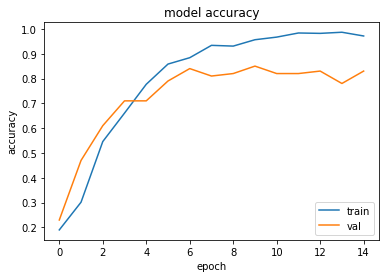

In [30]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

### Model2, above model is overfitting so lets enable BatchNormalization to address overfitting issue

In [31]:
#All the hyperparameters
hyper_img_per_sequence = 15
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_epoch = 15

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(hyper_img_height, hyper_img_width))
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = imresize(image, (hyper_img_height, hyper_img_width))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [33]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model = Sequential()
model.add(Conv3D(32, (3, 3, 3),  padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 15
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 15, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 100, 100, 32)  128       
_________________________________________________________________
activation_10 (Activation)   (None, 15, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 7, 50, 50, 32)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 7, 50, 50, 64)     16448     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 50, 50, 64)     256       
__________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/15
19/21 [==========================>...] - ETA: 55s - loss: 59.0212 - categorical_accuracy: 0.2476 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


21/21 [==============================] - 602s 28s/step - loss: 56.3118 - categorical_accuracy: 0.2472 - val_loss: 3.6575 - val_categorical_accuracy: 0.2700
Epoch 2/15
21/21 [==============================] - 600s 29s/step - loss: 1.5862 - categorical_accuracy: 0.2478 - val_loss: 2.6999 - val_categorical_accuracy: 0.2800
Epoch 3/15
21/21 [==============================] - 603s 29s/step - loss: 1.5623 - categorical_accuracy: 0.2152 - val_loss: 1.6033 - val_categorical_accuracy: 0.3500
Epoch 4/15
21/21 [==============================] - 599s 29s/step - loss: 1.5778 - categorical_accuracy: 0.2470 - val_loss: 1.5878 - val_categorical_accuracy: 0.2300
Epoch 5/15
21/21 [==============================] - 600s 29s/step - loss: 1.5944 - categorical_accuracy: 0.2289 - val_loss: 1.6073 - val_categorical_accuracy: 0.2300
Epoch 6/15
21/21 [==============================] - 607s 29s/step - loss: 1.5722 - categorical_accuracy: 0.2336 - val_loss: 1.5809 - val_categorical_accuracy: 0.2300
Epoch 7/15
21/

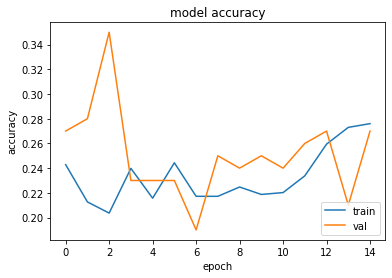

In [34]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

### Model3. Above model seems to be not learning, so lets add 1 more conv3D layer & reduce parameters count by adding 1 more Dense layer with .5 dropouts

In [37]:
#All the hyperparameters
hyper_img_per_sequence = 15
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_epoch = 25

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(hyper_img_height, hyper_img_width))
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = imresize(image, (hyper_img_height, hyper_img_width))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [36]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model = Sequential()
model.add(Conv3D(16, (2, 2, 2),padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Conv3D(32, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(num_classes,activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 25
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 15, 100, 100, 16)  400       
_________________________________________________________________
activation_12 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 7, 50, 50, 32)     4128      
_________________________________________________________________
activation_13 (Activation)   (None, 7, 50, 50, 32)     0         
__________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/25
19/21 [==========================>...] - ETA: 29s - loss: 8.5548 - categorical_accuracy: 0.2475

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


21/21 [==============================] - 325s 15s/step - loss: 8.4477 - categorical_accuracy: 0.2565 - val_loss: 1.5111 - val_categorical_accuracy: 0.3400
Epoch 2/25
21/21 [==============================] - 318s 15s/step - loss: 2.6107 - categorical_accuracy: 0.4553 - val_loss: 6.7807 - val_categorical_accuracy: 0.2300
Epoch 3/25
21/21 [==============================] - 324s 15s/step - loss: 1.5832 - categorical_accuracy: 0.4475 - val_loss: 13.3552 - val_categorical_accuracy: 0.1500
Epoch 4/25
21/21 [==============================] - 316s 15s/step - loss: 1.3099 - categorical_accuracy: 0.4962 - val_loss: 15.5713 - val_categorical_accuracy: 0.2100
Epoch 5/25
21/21 [==============================] - 324s 15s/step - loss: 1.1704 - categorical_accuracy: 0.5146 - val_loss: 16.9860 - val_categorical_accuracy: 0.2100
Epoch 6/25
21/21 [==============================] - 319s 15s/step - loss: 1.1100 - categorical_accuracy: 0.5584 - val_loss: 17.3898 - val_categorical_accuracy: 0.2000
Epoch 7/25


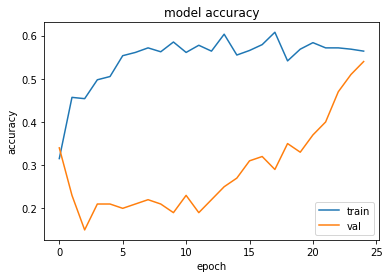

In [38]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

### Model4. Overfitting issue resolved to great extent in above model, now will try to increase accuracy by adding 1 more conv3d layer

In [8]:
#All the hyperparameters
hyper_img_per_sequence = 15
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_epoch = 35

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(hyper_img_height, hyper_img_width))
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = imresize(image, (hyper_img_height, hyper_img_width))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 35
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model = Sequential()
model.add(Conv3D(16, (2, 2, 2),padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Conv3D(32, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Conv3D(128, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(num_classes,activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 35
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 50, 50, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 7, 50, 50, 32)     0         
____________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/35
19/21 [==========================>...] - ETA: 2:20 - loss: 4.3631 - categorical_accuracy: 0.2961

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


21/21 [==============================] - 1686s 80s/step - loss: 4.1863 - categorical_accuracy: 0.2881 - val_loss: 1.6251 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/35
21/21 [==============================] - 332s 16s/step - loss: 1.3615 - categorical_accuracy: 0.4419 - val_loss: 2.6628 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/35
21/21 [==============================] - 332s 16s/step - loss: 1.2255 - categorical_accuracy: 0.4962 - val_loss: 3.5755 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 4/35
21/21 [==============================] - 330s 16s/step - loss: 1.1092 - categorical_accuracy: 0.5641 - val_loss: 3.9893 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 5/35
21/21 [==============================] - 335s 16s/step - loss: 1.0731 - categorical_accuracy: 0.5807 - val_loss: 4.5018 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 6/35
21/21 [==============================] - 332s 16s/step - loss: 0.9380 - categorical_accuracy: 0.

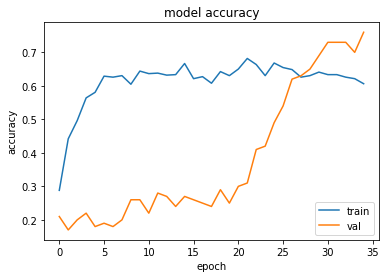

In [10]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

### Model5, Remove last dense layer & add dropout to flatten layer to check if it increase the accuracy

In [10]:
#All the hyperparameters
hyper_img_per_sequence = 15
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_epoch = 35

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(hyper_img_height, hyper_img_width))
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = imresize(image, (hyper_img_height, hyper_img_width))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 35
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model = Sequential()
model.add(Conv3D(16, (2, 2, 2),padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Conv3D(32, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Conv3D(128, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 35
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 16)  400       
_________________________________________________________________
activation (Activation)      (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 50, 50, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 7, 50, 50, 32)     0         
____________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Epoch 1/35
19/21 [==========================>...] - ETA: 2:57 - loss: 4.3809 - categorical_accuracy: 0.3717

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


21/21 [==============================] - 2118s 101s/step - loss: 4.1689 - categorical_accuracy: 0.3831 - val_loss: 1.5340 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/35
21/21 [==============================] - 357s 17s/step - loss: 1.1359 - categorical_accuracy: 0.5807 - val_loss: 3.6297 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/35
21/21 [==============================] - 344s 16s/step - loss: 0.8444 - categorical_accuracy: 0.6621 - val_loss: 6.0372 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 4/35
21/21 [==============================] - 352s 17s/step - loss: 0.6563 - categorical_accuracy: 0.7662 - val_loss: 7.8976 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 5/35
21/21 [==============================] - 345s 16s/step - loss: 0.5982 - categorical_accuracy: 0.7813 - val_loss: 9.5387 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 6/35
21/21 [==============================] - 354s 17s/step - loss: 0.5823 - categorical_accuracy: 0

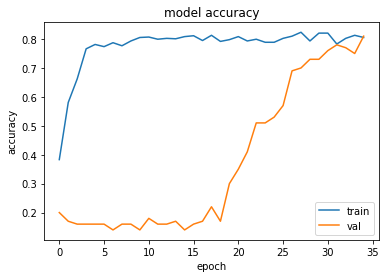

In [13]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

### Model6, above model accuracy has been improved further.lets add strides to model to check if accuracy improves further by reducing parameter counts

In [ ]:
#All the hyperparameters
hyper_img_per_sequence = 15
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_epoch = 25

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(hyper_img_height, hyper_img_width))
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = imresize(image, (hyper_img_height, hyper_img_width))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model = Sequential()
model.add(Conv3D(16, (2, 2, 2),strides=(2, 2, 2),padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Conv3D(32, (2, 2, 2),strides=(2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2),strides=(2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Conv3D(128, (2, 2, 2),strides=(2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_18 (Conv3D)           (None, 8, 50, 50, 16)     400       
_________________________________________________________________
activation_18 (Activation)   (None, 8, 50, 50, 16)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 50, 50, 16)     64        
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 4, 25, 25, 16)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 2, 13, 13, 32)     4128      
_________________________________________________________________
activation_19 (Activation)   (None, 2, 13, 13, 32)     0         
_________________________________________________________________
batch_

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 3/21 [===>..........................] - ETA: 39s - loss: 2.1540 - categorical_accuracy: 0.2604

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 39s 2s/step - loss: 1.8936 - categorical_accuracy: 0.2924 - val_loss: 1.5683 - val_categorical_accuracy: 0.3800
Epoch 2/25
21/21 [==============================] - 35s 2s/step - loss: 1.5743 - categorical_accuracy: 0.4152 - val_loss: 1.5019 - val_categorical_accuracy: 0.4100
Epoch 3/25
21/21 [==============================] - 35s 2s/step - loss: 1.3271 - categorical_accuracy: 0.4954 - val_loss: 1.2987 - val_categorical_accuracy: 0.5400
Epoch 4/25
21/21 [==============================] - 35s 2s/step - loss: 1.2300 - categorical_accuracy: 0.4930 - val_loss: 1.2666 - val_categorical_accuracy: 0.5000
Epoch 5/25
21/21 [==============================] - 35s 2s/step - loss: 1.0742 - categorical_accuracy: 0.5876 - val_loss: 1.5397 - val_categorical_accuracy: 0.4700
Epoch 6/25
21/21 [==============================] - 35s 2s/step - loss: 1.0237 - categorical_accuracy: 0.6006 - val_loss: 1.2102 - val_categorical_accuracy: 0.5500
Epoch 7/25
21/21 [=========

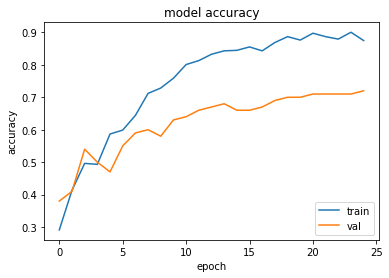

In [ ]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

### Model7,Lets decrease image per sequence count to 10 to model5 which is best perfoming till time.

In [ ]:
#All the hyperparameters
hyper_img_per_sequence = 10
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_epoch = 35

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = imresize(image,(hyper_img_height, hyper_img_width))
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = imresize(image, (hyper_img_height, hyper_img_width))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 35
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model = Sequential()
model.add(Conv3D(16, (2, 2, 2),padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Conv3D(32, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Conv3D(128, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 35
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 10, 100, 100, 16)  400       
_________________________________________________________________
activation_22 (Activation)   (None, 10, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 10, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 5, 50, 50, 16)     0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 5, 50, 50, 32)     4128      
_________________________________________________________________
activation_23 (Activation)   (None, 5, 50, 50, 32)     0         
_________________________________________________________________
batch_

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/21 [=>............................] - ETA: 1:23 - loss: 4.9214 - categorical_accuracy: 0.2031

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21/21 [==============================] - 79s 4s/step - loss: 2.8974 - categorical_accuracy: 0.3882 - val_loss: 1.6520 - val_categorical_accuracy: 0.3900
Epoch 2/35
21/21 [==============================] - 23s 1s/step - loss: 1.2369 - categorical_accuracy: 0.5373 - val_loss: 1.0457 - val_categorical_accuracy: 0.5700
Epoch 3/35
21/21 [==============================] - 24s 1s/step - loss: 0.9782 - categorical_accuracy: 0.6183 - val_loss: 1.0095 - val_categorical_accuracy: 0.5400
Epoch 4/35
21/21 [==============================] - 24s 1s/step - loss: 0.7768 - categorical_accuracy: 0.6955 - val_loss: 0.7733 - val_categorical_accuracy: 0.7500
Epoch 5/35
21/21 [==============================] - 24s 1s/step - loss: 0.6636 - categorical_accuracy: 0.7517 - val_loss: 1.0832 - val_categorical_accuracy: 0.5800
Epoch 6/35
21/21 [==============================] - 24s 1s/step - loss: 0.5923 - categorical_accuracy: 0.7668 - val_loss: 0.5994 - val_categorical_accuracy: 0.7300
Epoch 7/35
21/21 [=========

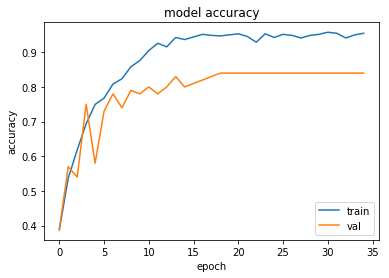

In [ ]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

### Model8,Decrease in image per sequence counts in above model leads to slight overfitting so will keep it to 15 & lets add image cropping to model

In [ ]:
#data resizing - Resizing all the images, so we can have all the images in a specific size
def crop_resize_img(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = imresize(img, (100,100))
    return resized_image

In [ ]:
#All the hyperparameters
hyper_img_per_sequence = 15
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_epoch = 35

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = crop_resize_img(image)
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_resize_img(image)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 35
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model = Sequential()
model.add(Conv3D(16, (2, 2, 2),padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Conv3D(32, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Conv3D(128, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 35
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_26 (Conv3D)           (None, 15, 100, 100, 16)  400       
_________________________________________________________________
activation_26 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 7, 50, 50, 32)     4128      
_________________________________________________________________
activation_27 (Activation)   (None, 7, 50, 50, 32)     0         
_________________________________________________________________
batch_

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


 3/21 [===>..........................] - ETA: 41s - loss: 6.9564 - categorical_accuracy: 0.2292

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


21/21 [==============================] - 36s 2s/step - loss: 4.7116 - categorical_accuracy: 0.3352 - val_loss: 1.7047 - val_categorical_accuracy: 0.4700
Epoch 2/35
21/21 [==============================] - 32s 2s/step - loss: 1.3378 - categorical_accuracy: 0.5299 - val_loss: 1.1097 - val_categorical_accuracy: 0.5300
Epoch 3/35
21/21 [==============================] - 32s 2s/step - loss: 1.0157 - categorical_accuracy: 0.5669 - val_loss: 0.9246 - val_categorical_accuracy: 0.6000
Epoch 4/35
21/21 [==============================] - 32s 2s/step - loss: 0.9326 - categorical_accuracy: 0.6356 - val_loss: 0.8930 - val_categorical_accuracy: 0.6600
Epoch 5/35
21/21 [==============================] - 32s 2s/step - loss: 0.7761 - categorical_accuracy: 0.6799 - val_loss: 0.7120 - val_categorical_accuracy: 0.7500
Epoch 6/35
21/21 [==============================] - 33s 2s/step - loss: 0.7724 - categorical_accuracy: 0.7138 - val_loss: 1.0060 - val_categorical_accuracy: 0.6600
Epoch 7/35
21/21 [=========

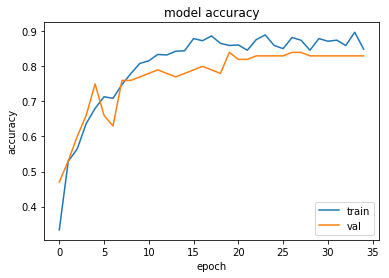

In [ ]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

### Model 9,above model performance has been improved significantly by adding image cropping.Lets try Changing the normalization to min-max

In [ ]:
def normalize_image(img):
    #using percentile for normalization for images, as min-max is giving better results.
    # normalized_image= img - np.percentile(img,15)/ np.percentile(img,85) - np.percentile(img,15) 
    normalized_image= (img - np.min(img))/(np.max(img)- np.min(img))
    return normalized_image

In [ ]:
#All the hyperparameters
hyper_img_per_sequence = 15
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_epoch = 35

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = crop_resize_img(image)
                                        
                    batch_data[folder,idx,:,:,0] = normalize_image(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = normalize_image(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = normalize_image(image[:,:,2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_resize_img(image)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = normalize_image(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = normalize_image(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = normalize_image(image[:,:,2])

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 35
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model = Sequential()
model.add(Conv3D(16, (2, 2, 2),padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Conv3D(32, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Conv3D(128, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_9' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 35
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_30 (Conv3D)           (None, 15, 100, 100, 16)  400       
_________________________________________________________________
activation_30 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_31 (Conv3D)           (None, 7, 50, 50, 32)     4128      
_________________________________________________________________
activation_31 (Activation)   (None, 7, 50, 50, 32)     0         
_________________________________________________________________
batch_

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


 3/21 [===>..........................] - ETA: 47s - loss: 7.4604 - categorical_accuracy: 0.1875

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


21/21 [==============================] - 40s 2s/step - loss: 4.6881 - categorical_accuracy: 0.3402 - val_loss: 1.5454 - val_categorical_accuracy: 0.5700
Epoch 2/35
21/21 [==============================] - 35s 2s/step - loss: 1.5016 - categorical_accuracy: 0.4439 - val_loss: 1.2035 - val_categorical_accuracy: 0.5100
Epoch 3/35
21/21 [==============================] - 35s 2s/step - loss: 1.1471 - categorical_accuracy: 0.5129 - val_loss: 1.0643 - val_categorical_accuracy: 0.6400
Epoch 4/35
21/21 [==============================] - 35s 2s/step - loss: 0.9779 - categorical_accuracy: 0.5881 - val_loss: 0.9837 - val_categorical_accuracy: 0.6200
Epoch 5/35
21/21 [==============================] - 35s 2s/step - loss: 0.9002 - categorical_accuracy: 0.6352 - val_loss: 0.9992 - val_categorical_accuracy: 0.6800
Epoch 6/35
21/21 [==============================] - 35s 2s/step - loss: 0.8628 - categorical_accuracy: 0.6451 - val_loss: 0.9255 - val_categorical_accuracy: 0.6500
Epoch 7/35
21/21 [=========

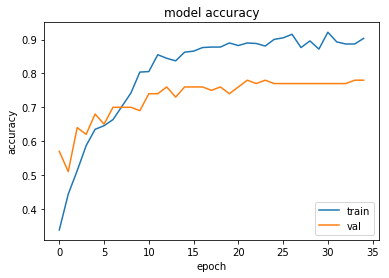

In [ ]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

##### min-max normalization has reduces the model performance so will keep normalization to image/255 for further testings

### Model 10, Conv2D+RNN model to train

#### Normalization-image ch/255, Using image croping, images per sequence-15, Batch Size-32,image size-100x100,model-3conv2d+1GRU+Softmax layers

In [ ]:
#All the hyperparameters
hyper_img_per_sequence = 15
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_Conv2D_layers_1 = 32
hyper_Conv2D_layers_2 = 64
hyper_Conv2D_layers_3 = 128
hyper_GRU_layer = 128
hyper_epoch = 35

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = crop_resize_img(image)
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_resize_img(image)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 35
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()

input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model.add(TimeDistributed(Conv2D(hyper_Conv2D_layers_1, (3, 3), activation='relu'),input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(1, 1))))

model.add(TimeDistributed(Conv2D(hyper_Conv2D_layers_2, (4,4), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(hyper_Conv2D_layers_3, (4,4), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))
model.add(GRU(hyper_GRU_layer, return_sequences=False, dropout=0.5))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_10' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 35
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 98, 98, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 98, 98, 32)    128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 97, 97, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 94, 94, 64)    32832     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 94, 94, 64)    256       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 47, 47, 64)    0         
_________________________________________________________________
time_d

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


21/21 [==============================] - 59s 3s/step - loss: 1.4575 - categorical_accuracy: 0.4087 - val_loss: 1.2203 - val_categorical_accuracy: 0.4700
Epoch 2/35
21/21 [==============================] - 40s 2s/step - loss: 0.8306 - categorical_accuracy: 0.6808 - val_loss: 1.0041 - val_categorical_accuracy: 0.6600
Epoch 3/35
21/21 [==============================] - 40s 2s/step - loss: 0.7094 - categorical_accuracy: 0.7430 - val_loss: 1.0684 - val_categorical_accuracy: 0.5700
Epoch 4/35
21/21 [==============================] - 40s 2s/step - loss: 0.5936 - categorical_accuracy: 0.8068 - val_loss: 1.2137 - val_categorical_accuracy: 0.5600
Epoch 5/35
21/21 [==============================] - 40s 2s/step - loss: 0.4441 - categorical_accuracy: 0.8625 - val_loss: 0.9814 - val_categorical_accuracy: 0.5900
Epoch 6/35
21/21 [==============================] - 40s 2s/step - loss: 0.3576 - categorical_accuracy: 0.9110 - val_loss: 0.8624 - val_categorical_accuracy: 0.6000
Epoch 7/35
21/21 [=========

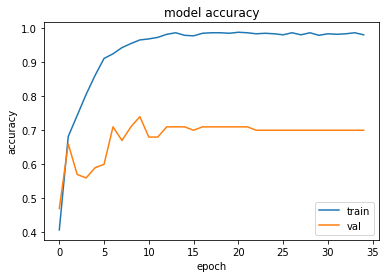

In [ ]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

### Model 11.Above model is overfitting so lets try by reducing the image per sequence to 10 & reduce image resolution to 80x80,remove stride

In [ ]:
#data resizing - Resizing all the images, so we can have all the images in a specific size
def crop_resize_img_new(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = imresize(img, (80,80))
    return resized_image

In [ ]:
#All the hyperparameters
hyper_img_per_sequence = 10
hyper_img_height = 80
hyper_img_width = 80
hyper_batch_size = 32
hyper_Conv2D_layers_1 = 32
hyper_Conv2D_layers_2 = 64
hyper_Conv2D_layers_3 = 128
hyper_GRU_layer = 128
hyper_epoch = 35

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = crop_resize_img_new(image)
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_resize_img_new(image)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 35
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()

input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model.add(TimeDistributed(Conv2D(hyper_Conv2D_layers_1, (3, 3), activation='relu'),input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(hyper_Conv2D_layers_2, (4,4), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(hyper_Conv2D_layers_3, (4,4), activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))
model.add(GRU(hyper_GRU_layer, return_sequences=False, dropout=0.5))

model.add(Dense(5, activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_11' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 35
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 10, 78, 78, 32)    896       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 10, 78, 78, 32)    128       
_________________________________________________________________
time_distributed_23 (TimeDis (None, 10, 39, 39, 32)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 10, 36, 36, 64)    32832     
_________________________________________________________________
time_distributed_25 (TimeDis (None, 10, 36, 36, 64)    256       
_________________________________________________________________
time_distributed_26 (TimeDis (None, 10, 18, 18, 64)    0         
_________________________________________________________________
time_d

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


21/21 [==============================] - 24s 1s/step - loss: 1.5271 - categorical_accuracy: 0.4124 - val_loss: 1.5412 - val_categorical_accuracy: 0.4000
Epoch 2/35
21/21 [==============================] - 19s 898ms/step - loss: 1.0530 - categorical_accuracy: 0.5898 - val_loss: 1.5142 - val_categorical_accuracy: 0.4200
Epoch 3/35
21/21 [==============================] - 20s 968ms/step - loss: 0.8366 - categorical_accuracy: 0.6642 - val_loss: 1.3564 - val_categorical_accuracy: 0.4700
Epoch 4/35
21/21 [==============================] - 20s 948ms/step - loss: 0.7114 - categorical_accuracy: 0.7480 - val_loss: 0.9950 - val_categorical_accuracy: 0.6100
Epoch 5/35
21/21 [==============================] - 20s 939ms/step - loss: 0.6025 - categorical_accuracy: 0.7714 - val_loss: 1.2590 - val_categorical_accuracy: 0.5000
Epoch 6/35
21/21 [==============================] - 20s 941ms/step - loss: 0.5409 - categorical_accuracy: 0.8003 - val_loss: 0.9715 - val_categorical_accuracy: 0.6700
Epoch 7/35
2

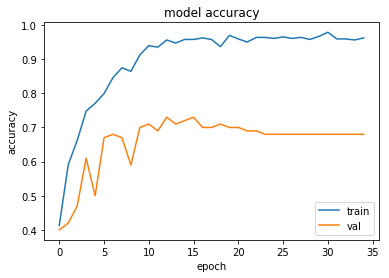

In [ ]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

### Model 12.Lets add 1 more conv2d & 1Dense layer to check if performance improves & address above overfitting issue

In [ ]:
#All the hyperparameters
hyper_img_per_sequence = 15
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_Conv2D_layers_1 = 16
hyper_Conv2D_layers_2 = 32
hyper_Conv2D_layers_3 = 64
hyper_Conv2D_layers_4 = 128
hyper_GRU_layer = 128
hyper_epoch = 35

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = crop_resize_img(image)
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_resize_img(image)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 35
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()

input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model.add(TimeDistributed(Conv2D(hyper_Conv2D_layers_1, (3, 3), padding='same', activation='relu'),input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(hyper_Conv2D_layers_2, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(hyper_Conv2D_layers_3, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(hyper_Conv2D_layers_3, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))
model.add(GRU(hyper_GRU_layer, return_sequences=False, dropout=0.5))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
          
model.add(Dense(5, activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_12' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 35
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_31 (TimeDis (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_32 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_33 (TimeDis (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_35 (TimeDis (None, 15, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_36 (TimeDis (None, 15, 25, 25, 32)    0         
_________________________________________________________________
time_d

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


 1/21 [>.............................] - ETA: 2:32 - loss: 1.9359 - categorical_accuracy: 0.1562

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


21/21 [==============================] - 39s 2s/step - loss: 1.5926 - categorical_accuracy: 0.2911 - val_loss: 1.2677 - val_categorical_accuracy: 0.4700
Epoch 2/35
21/21 [==============================] - 31s 1s/step - loss: 1.2560 - categorical_accuracy: 0.4353 - val_loss: 1.2057 - val_categorical_accuracy: 0.5200
Epoch 3/35
21/21 [==============================] - 34s 2s/step - loss: 1.0936 - categorical_accuracy: 0.5474 - val_loss: 1.2611 - val_categorical_accuracy: 0.4900
Epoch 4/35
21/21 [==============================] - 32s 2s/step - loss: 1.0584 - categorical_accuracy: 0.5496 - val_loss: 0.9758 - val_categorical_accuracy: 0.6200
Epoch 5/35
21/21 [==============================] - 33s 2s/step - loss: 0.8957 - categorical_accuracy: 0.6341 - val_loss: 0.9450 - val_categorical_accuracy: 0.6600
Epoch 6/35
21/21 [==============================] - 33s 2s/step - loss: 0.7589 - categorical_accuracy: 0.6970 - val_loss: 0.8372 - val_categorical_accuracy: 0.6400
Epoch 7/35
21/21 [=========

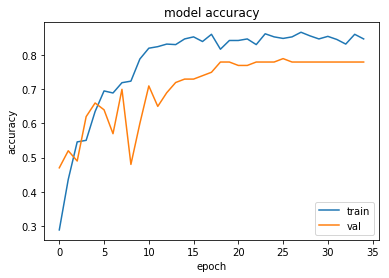

In [ ]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

##### Above model12 performs better incomparision to other 2 Conv2D+CNN models & it also addressed overfitting issue to great extent

### FINAL Model
###### From all above 12 models experiments we can conclude that Model 8 is performing best so now will train our final model & save its parameters weights to .h5 file

In [ ]:
#All the hyperparameters
hyper_img_per_sequence = 15
hyper_img_height = 100
hyper_img_width = 100
hyper_batch_size = 32
hyper_epoch = 35

batch_size = hyper_batch_size #experiment with the batch size

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,30//hyper_img_per_sequence)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        x = hyper_img_per_sequence
        y = hyper_img_height
        z = hyper_img_width
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = crop_resize_img(image)
                                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches
        batch_remaining = len(folder_list) % batch_size
        if(batch_remaining > 0):
            batch = num_batches
            batch_data = np.zeros((batch_remaining,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_remaining,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_remaining): # iterate over the batch_remaining
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = crop_resize_img(image)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 35
print ('# epochs =', num_epochs)
num_classes = 5


from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


input_shape=(hyper_img_per_sequence, hyper_img_height, hyper_img_width, 3)

model = Sequential()
model.add(Conv3D(16, (2, 2, 2),padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Conv3D(32, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Conv3D(128, (2, 2, 2),  padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),  padding='same'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))


optimiser = 'adam' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_final1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
training = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# training sequences = 663
# validation sequences = 100
# epochs = 35
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 15, 100, 100, 16)  400       
_________________________________________________________________
activation_5 (Activation)    (None, 15, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 7, 50, 50, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 7, 50, 50, 32)     4128      
_________________________________________________________________
activation_6 (Activation)    (None, 7, 50, 50, 32)     0         
_________________________________________________________________
batch_

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


 3/21 [===>..........................] - ETA: 43s - loss: 6.8352 - categorical_accuracy: 0.2708

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


21/21 [==============================] - 40s 2s/step - loss: 7.4236 - categorical_accuracy: 0.2836 - val_loss: 5.9758 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_final1_2020-09-1322_29_42.007036/model-00001-7.42893-0.28507-5.97578-0.44000.h5
Epoch 2/35
21/21 [==============================] - 36s 2s/step - loss: 3.3325 - categorical_accuracy: 0.4383 - val_loss: 1.3332 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_final1_2020-09-1322_29_42.007036/model-00002-3.35802-0.43891-1.33323-0.50000.h5
Epoch 3/35
21/21 [==============================] - 36s 2s/step - loss: 1.2381 - categorical_accuracy: 0.5260 - val_loss: 1.0870 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_final1_2020-09-1322_29_42.007036/model-00003-1.24062-0.52489-1.08699-0.58000.h5
Epoch 4/35
21/21 [==============================] - 36s 2s/step - loss: 0.9703 - categorical_accuracy: 0.5781 - val_loss: 0.8319 - val_categorical_accuracy: 0.7000

Epoch 

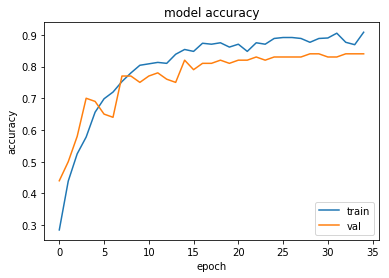

In [ ]:
from matplotlib import pyplot as plt

# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()